<a href="https://colab.research.google.com/github/MaxMaffio/InterviewQuery/blob/main/Uber_Uber_Data_Science_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![logo.png](https://github.com/interviewquery/takehomes/blob/origin/uber_3/uber_3/logo.png?raw=1)


## Part 1 - SQL Syntax

Given the below subset of Uber's schema, write executable SQL queries to answer the questions below. Please answer in a single query for each question and assume read-only access to the database (i.e. do not use CREATE TABLE).

1. For each of the cities 'Qarth' and 'Meereen', calculate 90 th percentile difference between Actual and Predicted ETA for all completed trips within the last 30 days.

2. A signup is defined as an event labeled `sign_up_success` within the `events` table. For each city ('Qarth' and 'Meereen') and each day of the week, determine the percentage of signups in the first week of 2016 that resulted in completed a trip within 168 hours of the sign up date.

**Assume a PostgreSQL database, server timezone is UTC.**


Table Name: **`trips`**

|Column Name:|Datatype:|
| :-: | :-: |
|`id`|`integer`|
|`client_id`|`integer` (Foreign keyed to `events.rider_id`)|
|`driver_id`|`integer`|
|`city_id`|`integer` (Foreign keyed to `cities.city_id`)|
|`client_rating`|`integer`|
|`driver_rating`|`integer`|
|`request_at`|`Timestamp with timezone`|
|`predicted_eta`|`integer`|
|`actual_eta`|`integer`|
|`status`|`Enum`(‘`completed`’, ‘`cancelled_by_driver`’, ‘`cancelled_by_client`’)|


Table Name: **`cities`**

|Column Name:|Datatype:|
| :-: | :-: |
|`city_id`|`integer`|
|`city_name`|`string`|



Table Name: **`events`**

|Column Name:|Datatype:|
| :-: | :-: |
|`device_id`|`integer`|
|`rider_id`|`integer`|
|`city_id`|`integer`|
|`event_name`|`Enum`(‘`sign_up_success`’, ‘`attempted_sign_up`’, ‘`sign_up_failure`’)|



## Part 2 - Experiment and metrics design


The Driver Experience team has just finished [redesigning the Uber Partner app](https://newsroom.uber.com/new-partner-app/). The new version expands the purpose of the app beyond just driving. It includes additional information on earnings, ratings, and provides a unified platform for Uber to communicate with its partners.

1. Propose and define the primary success metric of the redesigned app. What are 2-3 additional tracking metrics that will be important to monitor in addition to the success metric defined above?

2. Outline a testing plan to evaluate if redesigned app performs better (according to the metrics you outlined). How would you balance the need to deliver quick results, with statistical rigor, and while still monitoring for risks?

3. Explain how you would translate the results from the testing plan into a decision on whether to launch the new design or roll it back.

## Part 3 - Data analysis

Uber's Driver team is interested in predicting which driver signups are most likely to start driving. To help explore this question, we have provided a sample  dataset of a cohort of driver signups in January 2015.The data was pulled a few months after they signed up to include the result of whether they actually completed their first trip. It also includes several pieces of background information gather about the driver and their car.

We would like you to use this data set to help understand what factors are best at predicting whether a signup will start to drive, and offer suggestions to operationalize those insights to help Uber.

See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. Please also call out any data related assumptions or issues that you encounter.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver signups took a first trip?

2. Build a predictive model to help Uber determine whether or not a driver signup will start driving. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Uber might leverage the insights gained from the model to generate more first trips (again, a few ideas/sentences will suffice).



### Data description

**id**: driver_id

**city_id**: city_id this user signed up in

**signup_os**: signup device of the user ("android", "ios", "website", "other")

**signup_channel**: what channel did the driver sign up from ("offline", "paid", "organic", "referral")

**signup_timestamp**: timestamp of account creation; local time in the form 'YYYY/MM/DD'

**bgc_date**: date of background check consent; in the form 'YYYY/MM/DD'

**vehicle_added_date**: date when driver's vehicle information was uploaded; in the form 'YYYY/MM/DD'

**first_trip_date**: date of the first trip as a driver; in the form 'YYYY/MM/DD'

**vehicle_make**: make of vehicle uploaded (i.e. Honda, Ford, Kia)

**vehicle_model**: model of vehicle uploaded (i.e. Accord, Prius, 350z)

**vehicle year**: year that the car was made; in the form 'YYYY'




Please note that this data is fake and does not represent actual driver signup behavior



In [22]:
!git clone --branch origin/uber_3 https://github.com/interviewquery/takehomes.git
%cd takehomes/uber_3
!if [[ $(ls *.zip) ]]; then unzip *.zip; fi
!ls

fatal: destination path 'takehomes' already exists and is not an empty directory.
/content/takehomes/uber_3/takehomes/uber_3
ls: cannot access '*.zip': No such file or directory
ds_challenge_v2_1_data.csv  logo.png  takehomefile.ipynb




---



# PART 1

Table Name: **`trips`**

|Column Name:|Datatype:|
| :-: | :-: |
|`id`|`integer`|
|`client_id`|`integer` (Foreign keyed to `events.rider_id`)|
|`driver_id`|`integer`|
|`city_id`|`integer` (Foreign keyed to `cities.city_id`)|
|`client_rating`|`integer`|
|`driver_rating`|`integer`|
|`request_at`|`Timestamp with timezone`|
|`predicted_eta`|`integer`|
|`actual_eta`|`integer`|
|`status`|`Enum`(‘`completed`’, ‘`cancelled_by_driver`’, ‘`cancelled_by_client`’)|


Table Name: **`cities`**

|Column Name:|Datatype:|
| :-: | :-: |
|`city_id`|`integer`|
|`city_name`|`string`|



Table Name: **`events`**

|Column Name:|Datatype:|
| :-: | :-: |
|`device_id`|`integer`|
|`rider_id`|`integer`|
|`city_id`|`integer`|
|`event_name`|`Enum`(‘`sign_up_success`’, ‘`attempted_sign_up`’, ‘`sign_up_failure`’)|


1. For each of the cities 'Qarth' and 'Meereen', calculate 90 th percentile difference between Actual and Predicted ETA for all completed trips within the last 30 days.



```
WITH df AS (
    SELECT * FROM trips As tr
    LEFT JOIN cities AS ci ON tr.city_id = ci.city_id
    WHERE ci.city_name IN ('Qarth', 'Meereen')
    AND tr.status = 'completed'
    AND tr.actual_eta IS NOT NULL
    AND tr.predicted_eta IS NOT NULL
    AND tr.request_at >= NOW() - INTERVAL '30 days'
)
SELECT
  city_name ,
  PERCENTILE_CONT(0.9) WITHIN GROUP (ORDER BY (actual_eta - predicted_eta)) AS 'percentile_90th_eta_difference'
FROM df
GROUP BY city_name
```



2. A signup is defined as an event labeled sign_up_success within the events table. For each city ('Qarth' and 'Meereen') and each day of the week, determine the percentage of signups in the first week of 2016 that resulted in completed a trip within 168 hours of the sign up date.



```
WITH signups AS (
    SELECT
        e.rider_id,
        c.city_name,
        DATEPART(WEEKDAY, e.event_timestamp) AS 'day_of_week',
        e.event_timestamp
    FROM events AS e
    LEFT JOIN cities AS c ON e.city_id = c.city_id
    WHERE c.city_name IN ('Qarth', 'Meereen')
    AND e.event_name = 'sign_up_success'
    AND e.event_timestamp >= '2016-01-01'
    AND e.event_timestamp < '2016-01-08'
),
completed_trips AS (
    SELECT
        t.client_id,
        t.request_at
    FROM trips AS t
    WHERE t.status = 'completed'
)
SELECT
    s.city_name,
    s.day_of_week,
    (COUNT(CASE WHEN ct.request_at IS NOT NULL AND ct.request_at <= s.event_timestamp + INTERVAL '168 hours' THEN 1 END)  / COUNT(*) * 100.0) AS 'percentage'
FROM signups AS s
LEFT JOIN completed_trips ct ON s.rider_id = ct.client_id
GROUP BY s.city_name, s.day_of_week
ORDER BY s.city_name ASC, s.day_of_week ASC
```



\

# PART 2

The Driver Experience team has just finished redesigning the Uber Partner app. The new version expands the purpose of the app beyond just driving. It includes additional information on earnings, ratings, and provides a unified platform for Uber to communicate with its partners.

Propose and define the primary success metric of the redesigned app. What are 2-3 additional tracking metrics that will be important to monitor in addition to the success metric defined above?

Outline a testing plan to evaluate if redesigned app performs better (according to the metrics you outlined). How would you balance the need to deliver quick results, with statistical rigor, and while still monitoring for risks?

Explain how you would translate the results from the testing plan into a decision on whether to launch the new design or roll it back.

First, I would conduct a **Data Analysis** on the users engagement factors, which identify if the the users engagement changed after the release of the new app. The factors are:
* time spent on the new app
* percentage of users looking on the new features in the app (earnings, ratings)
* chats frequency with partners
* rides-acceptance rates
* reviews of users (if any)

Secondly, I would design and conduct an **A/B Test**, in order to proof if the new app is successfulm and to check if it is worthy to extend it to the entire user population. Here the steps that I would follow:
1. define the primary success metric (OEC, Overall Evaluation Criteria): avg working daily time spent on the new app. The goal is to measure if with the new version, the users are more engaged and spend more time on looking at the earnings, ratings, chats sections.
2. Define the Null Hypothesis: the avg time spent in Control and Treatment group are the same   
$H_{0} : X_{C} = X_{T}  $   
$H_{0} : d = 0  $   
where:
* $X_{C}$: avg time spent on the app by users in the Control Group
* $X_{T}$: avg time spent on the app by users in the Treatment Group
* $d = X_{C} - X_{T}$
3. Significance level: 0.05; Power: 80%; size of the 2 groups
4. Build the Control and Treatment Groups, in order that they are comparable and good representation of the population
5. Collect the data
6. Run the Z-test statistics, calculate the p-value
7. results interpretation (Do we have enough evidence to Reject the Null Hypothesis?)
8. Compare the Confidence Interval with the Practical Decision Boundaries, in order to evaluate if it is worthy to launch the new design to the entire users population

Besides, we can define other 2-3 additional tracking metrics that will be important to monitor in addition to the success metric:
* avg time spent on the new sections of the app (earnings, ratings, chats with partners)
* frequency visualizations of earnings, ratings
* number of chats opened with partners
* number of users, in order to check that they will be stable or would increase. A decrease of number of users would mean that the app complicated the user experiences and they leave for a better app
* rides acceptance rate

--

*Example about the Practical Decision Boundaries:*

Suppose a practical decision boundaries of:  
* lower_boundary = -2
* upper_boundary = 2   
For the following Confidence Intervals:   
* CI=[5;8] : the new feature is statistically significant and practically significant   
* CI=[1;5] : the new feature is statistically significant but not practically significant     
* CI=[-1;5] : the new feature is not statistically significant and not practically significant




\

# PART 3

Uber's Driver team is interested in predicting which driver signups are most likely to start driving. To help explore this question, we have provided a sample  dataset of a cohort of driver signups in January 2015.The data was pulled a few months after they signed up to include the result of whether they actually completed their first trip. It also includes several pieces of background information gather about the driver and their car.

We would like you to use this data set to help understand **what factors are best at predicting whether a signup will start to drive,** and offer suggestions to operationalize those insights to help Uber.

See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. Please also call out any data related assumptions or issues that you encounter.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver signups took a first trip?

2. Build a predictive model to help Uber determine **whether or not a driver signup will start driving**. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Uber might leverage the insights gained from the model to generate more first trips (again, a few ideas/sentences will suffice).

### data description

**id**: driver_id

**city_id**: city_id this user signed up in

**signup_os**: signup device of the user ("android", "ios", "website", "other")

**signup_channel**: what channel did the driver sign up from ("offline", "paid", "organic", "referral")

**signup_timestamp**: timestamp of account creation; local time in the form 'YYYY/MM/DD'

**bgc_date**: date of background check consent; in the form 'YYYY/MM/DD'

**vehicle_added_date**: date when driver's vehicle information was uploaded; in the form 'YYYY/MM/DD'

**first_trip_date**: date of the first trip as a driver; in the form 'YYYY/MM/DD'

**vehicle_make**: make of vehicle uploaded (i.e. Honda, Ford, Kia)

**vehicle_model**: model of vehicle uploaded (i.e. Accord, Prius, 350z)

**vehicle year**: year that the car was made; in the form 'YYYY'

In [23]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRegressor
from xgboost import cv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller Test
import statsmodels.api as sma
import shap
import itertools
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
# Suppress warnings for cleaner output
warnings.simplefilter('ignore', ConvergenceWarning)
os.listdir()

['logo.png', 'ds_challenge_v2_1_data.csv', 'takehomefile.ipynb']

## read data

In [24]:
# read data
df = pd.read_csv("ds_challenge_v2_1_data.csv")

# print
print(df.shape)
df.head()

(54681, 11)


/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN


In [25]:
# adjust date variables
df["signup_date"] = pd.to_datetime(df["signup_date"])
df["bgc_date"] = pd.to_datetime(df["bgc_date"])
df["vehicle_added_date"] = pd.to_datetime(df["vehicle_added_date"])
df["first_completed_date"] = pd.to_datetime(df["first_completed_date"])
# difference in days between signup_date and vehicle_added_date
df["diff_signup_vehicle"] = (df["vehicle_added_date"] - df["signup_date"]).dt.days
# difference in days between signup_date and bcg_date
df["diff_signup_bcg"] = (df["bgc_date"] - df["signup_date"]).dt.days
# target column
df["d_start_drive"] = np.where(df["first_completed_date"].isna()==False,1,0)
# binary variable of bgc_date
df["d_bgc_date"] = np.where(df["bgc_date"].isna()==False,1,0)
# binary variable of vehicle_added_date
df["d_vehicle_added_date"] = np.where(df["vehicle_added_date"].isna()==False,1,0)
# print
df.head()

<ipython-input-25-30b787cae4b6>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-25-30b787cae4b6>:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-25-30b787cae4b6>:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

<ipython-input-25-30b787cae4b6>:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,diff_signup_vehicle,diff_signup_bcg,d_start_drive,d_bgc_date,d_vehicle_added_date
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT,NaN,NaN,0,0,0
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT,NaN,NaN,0,0,0
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT,NaN,0.0,0,1,0
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,2016-02-03,5.0,5.0,1,1,1
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,NaT,16.0,15.0,0,1,1


In [26]:
# check if sataset is unbalanced
df["d_start_drive"].value_counts(True)

,proportion
d_start_drive,
0,0.887767
1,0.112233


## explorative analysis

In [27]:
# bar charts of signups based on city and device
# prepare dataframe
df_grouped = df.groupby(["city_name", "signup_os"], as_index=False)["d_start_drive"].sum()

# preallocate fig
fig = go.Figure()

# first data
x_axis = sorted(df_grouped["city_name"].unique())
for item in df_grouped["signup_os"].unique():
  data = go.Bar(x=x_axis,
                y=df_grouped[df_grouped["signup_os"]==item]["d_start_drive"],
                name=item
                )
  fig.add_trace(data)

# layout
fig.update_layout(
    title_text='nr. signups based on city and device',
    yaxis_title_text='Count',
)
# print
fig.show()

In [28]:

# Calculate the percentage of drivers for each city and d_start_drive value
city_percentages = df.groupby('city_name')['d_start_drive'].value_counts(normalize=True).unstack() * 100

# Create the bar chart
fig = go.Figure()

# Add bars for d_start_drive = 1
fig.add_trace(go.Bar(
    x=city_percentages.index,
    y=city_percentages[1],
    name='d_start_drive = 1',
))

# Add bars for d_start_drive = 0
fig.add_trace(go.Bar(
    x=city_percentages.index,
    y=city_percentages[0],
    name='d_start_drive = 0'
))

# Update layout
fig.update_layout(
    title='Percentage of Drivers by City and d_start_drive',
    xaxis_title='City Name',
    yaxis_title='Percentage of Drivers',
    barmode='stack'
)

# Show the plot
fig.show()

In [29]:
# Calculate the percentage of drivers for each city and d_start_drive value
device_percentages = df.groupby('signup_os')['d_start_drive'].value_counts(normalize=True).unstack() * 100

# Create the bar chart
fig = go.Figure()

# Add bars for d_start_drive = 1
fig.add_trace(go.Bar(
    x=device_percentages.index,
    y=device_percentages[1],
    name='d_start_drive = 1',
))

# Add bars for d_start_drive = 0
fig.add_trace(go.Bar(
    x=device_percentages.index,
    y=device_percentages[0],
    name='d_start_drive = 0'
))



# Update layout
fig.update_layout(
    title='Percentage of Drivers by signup_os and d_start_drive',
    xaxis_title='signup_os',
    yaxis_title='Percentage of Drivers',
    barmode='stack'
)

# Show the plot
fig.show()

In [30]:
# Create the histogram chart
fig = go.Figure()

# Histogram for d_start_drive == 1
fig.add_trace(go.Histogram(
    x=df[df['d_start_drive'] == 1]['diff_signup_vehicle'],
    name='started driving'
))

# Histogram for d_start_drive == 0
fig.add_trace(go.Histogram(
    x=df[df['d_start_drive'] == 0]['diff_signup_vehicle'],
    name='not started driving'
))

fig.update_layout(
    barmode='overlay',
    title_text='Histogram of diff_signup_vehicle split by d_start_drive',
    xaxis_title_text='days',
    yaxis_title_text='Count',
)

fig.update_traces(opacity=0.75)
fig.show()

In [31]:
# Create the histogram chart
fig = go.Figure()

# Histogram for d_start_drive == 0
fig.add_trace(go.Histogram(
    x=df[df['d_start_drive'] == 0]['diff_signup_bcg'],
    name='not started driving',
     marker_color='#d62728'
))

# Histogram for d_start_drive == 1
fig.add_trace(go.Histogram(
    x=df[df['d_start_drive'] == 1]['diff_signup_bcg'],
    name='started driving',
    marker_color='#1f77b4'
))


fig.update_layout(
    barmode='overlay',
    title_text='Histogram of diff_signup_bcg split by d_start_drive',
    xaxis_title_text='days',
    yaxis_title_text='Count',
)

fig.update_traces(opacity=0.75)
fig.show()

In [32]:
# Calculate the correlation between 'd_start_drive', 'd_bgc_date', and 'd_vehicle_added_date'
correlation_matrix = df[['d_start_drive', 'd_bgc_date', 'd_vehicle_added_date']].corr()
correlation_matrix

,d_start_drive,d_bgc_date,d_vehicle_added_date
d_start_drive,1.000000,0.289346,0.596446
d_bgc_date,0.289346,1.000000,0.435250
d_vehicle_added_date,0.596446,0.435250,1.000000


## features engineering

In [33]:
# list of datetime variables
list_date_features = df.select_dtypes(include=['datetime']).columns.tolist()
# print
print(len(list_date_features))
print(list_date_features)

for col in list_date_features:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])


# Function to convert dates to numerical Excel format
def date_to_excel(dt):
    try:
        return dt.toordinal()  # Use toordinal for Excel-compatible numerical dates
    except AttributeError:
        return 0  # Handle non-date values gracefully
    except ValueError:
        return 0


for col in list_date_features:
    if col in df.columns:
        df[col + '_encode'] = df[col].apply(date_to_excel)

4
['signup_date', 'bgc_date', 'vehicle_added_date', 'first_completed_date']


In [34]:
df.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,diff_signup_vehicle,diff_signup_bcg,d_start_drive,d_bgc_date,d_vehicle_added_date,signup_date_encode,bgc_date_encode,vehicle_added_date_encode,first_completed_date_encode
0,1,Strark,ios web,Paid,2016-01-02,NaT,NaT,NaN,NaN,NaN,NaT,NaN,NaN,0,0,0,735965,0,0,0
1,2,Strark,windows,Paid,2016-01-21,NaT,NaT,NaN,NaN,NaN,NaT,NaN,NaN,0,0,0,735984,0,0,0
2,3,Wrouver,windows,Organic,2016-01-11,2016-01-11,NaT,NaN,NaN,NaN,NaT,NaN,0.0,0,1,0,735974,735974,0,0
3,4,Berton,android web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016.0,2016-02-03,5.0,5.0,1,1,1,735992,735997,735997,735997
4,5,Strark,android web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016.0,NaT,16.0,15.0,0,1,1,735973,735988,735989,0


## model

In [35]:
# defien the target
str_target_variable = 'd_start_drive'

### split train test set

In [36]:
# train and test set
X = df.copy()
y = df[str_target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(38276, 20)
(16405, 20)


### encode categorical variables

In [37]:
# list of categorical variables
list_cat_features = df.select_dtypes(include=['object']).columns.tolist()
# print
print(len(list_cat_features))
print(list_cat_features)

# encode the categoroical variable
for str_cat_feature in list_cat_features:
  df_encode = X_train.groupby(str_cat_feature, as_index=False).agg({"d_start_drive":"sum", "id":"count"})
  df_encode[str_cat_feature+"_encode"] = df_encode["d_start_drive"]/df_encode["id"]
  # merge the encoded variable with the main dataset
  X_train = X_train.merge(df_encode[[str_cat_feature, str_cat_feature+"_encode"]],
                on = str_cat_feature,
                how="left")
  # merge the encoded variable with the main dataset
  X_test = X_test.merge(df_encode[[str_cat_feature, str_cat_feature+"_encode"]],
                on = str_cat_feature,
                how="left")

5
['city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'vehicle_model']


### feature selection

In [38]:
list_features_encode = [
  'city_name_encode',
  'signup_os_encode',
  'signup_channel_encode',
  'vehicle_make_encode',
  'vehicle_model_encode',
]
# dates
list_dates_features_encode = [
  'signup_date_encode',
  'bgc_date_encode',
  'vehicle_added_date_encode',
  #'first_completed_date_encode',
]

# numerical features
list_num_features = [
  'vehicle_year',
  'diff_signup_vehicle',
  'diff_signup_bcg'
  ]
# target
str_target_variable = 'd_start_drive'

# list features
list_features = list_features_encode + list_dates_features_encode + list_num_features

# select the features
X_train = X_train[list_features].fillna(0)
X_test = X_test[list_features].fillna(0)

### paramert turning

In [43]:
'''
# run XGBoosting Regressor
## hyperparameters
param_grid = {
    'learning_rate': [0.1,0.2,0.5,0.7],
    'n_estimators': [80,100,150,200],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
}

# force hyperparameters, as Colab interrupt forcely the runtime
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2,],
    'n_estimators': [100,150,],
    'max_depth': [10,20 ],
    #'max_features': [2, 3],
    #'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
}

# evaluate the model
model = GradientBoostingClassifier()
# grid search cv
grid_search = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           cv = 3,
                           #n_jobs = -1,
                           verbose = True)
# fit the cv
grid_search.fit(X_train, y_train)

# best hyperparameters
param_best = grid_search.best_params_
'''
# fix them for simplicity
param_best = {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}

# print
param_best

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}

### fit

In [44]:

# Initialize and train the Gradient Boosting Regression model
gb_classifier = GradientBoostingClassifier(n_estimators=param_best["n_estimators"],
                                         learning_rate=param_best["learning_rate"],
                                         max_depth=3,
                                         random_state=42)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, random_state=42)

In [45]:
# Make predictions on the test set
y_pred = gb_classifier.predict(X_test)

### performances

In [46]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Calculate the confusion matrix
conf_matrix

Confusion Matrix:


array([[14040,   506],
       [  433,  1426]])

In [47]:
# false positive rate, false negative rate
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]
# Calculate the false positive rate (FPR)
FPR = FP / (FP + TN)
# Calculate the false negative rate (FNR)
FNR = FN / (FN + TP)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate the recall
recall = recall_score(y_test, y_pred)

# Calculate the precision
precision = precision_score(y_test, y_pred)

# print
pd.DataFrame({"Metric":["Accuracy", "Recall", "Precision", "False Positive Rate", "False Negative Rate"],
              "Value":[accuracy, recall, precision, FPR, FNR]})

,Metric,Value
0,Accuracy,0.942761
1,Recall,0.767079
2,Precision,0.738095
3,False Positive Rate,0.034786
4,False Negative Rate,0.232921


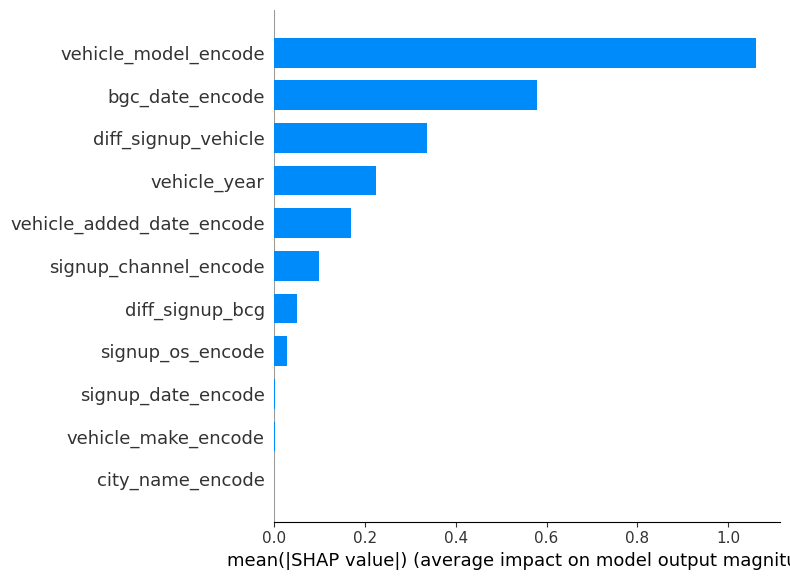

In [48]:
# Calculate SHAP values
explainer = shap.TreeExplainer(gb_classifier)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test,  plot_type="bar")

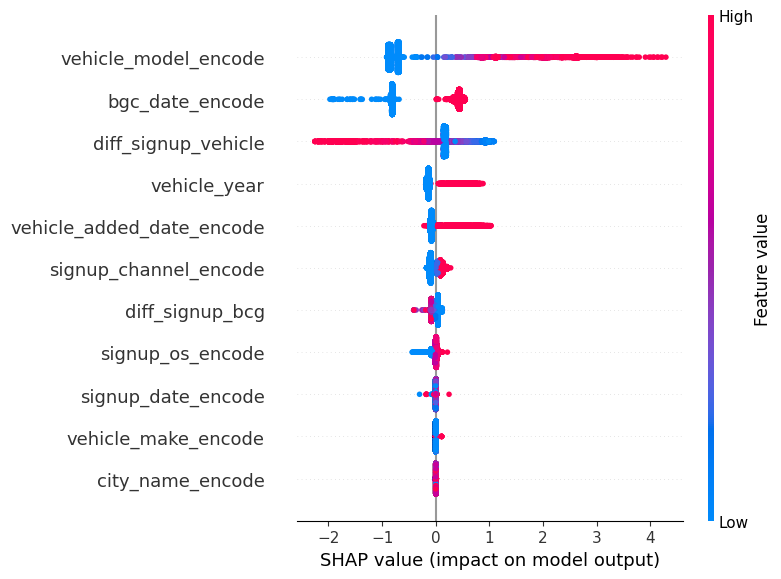

In [49]:
# Summary plot
shap.summary_plot(shap_values, X_test)